## RNN - AffWild2 - Proof of Concept

La idea de ésta 2da PoC es entrenar una RNN con nuestra CNN antepuesta utilizando un subset de 10 videos

## Libraries

In [23]:
import os
import cv2
import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as display

from PIL import Image, ImageDraw

from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Flatten, ConvLSTM2D, Reshape, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import Constant
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import EarlyStopping

set_seed(455)
np.random.seed(455)

## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Paths

In [3]:
DATASETS_PATH = "/content/drive/MyDrive/TPP/TPP - sisop?/Datasets/"
AFF_WILD2_PATH = DATASETS_PATH + "Aff-Wild2/"
AFF_WILD2_FRAMES_PATH = AFF_WILD2_PATH + "frames/48x48x1/"
AFF_WILD2_LABELS_PATH = AFF_WILD2_PATH + "Annotations/EXPR_Classification_Challenge/"

MODELS_PATH = "/content/drive/MyDrive/TPP/TPP - sisop?/Modelos/"

# Consts

In [4]:
WIDTH = 48
HEIGHT = 48

# Functions

In [5]:
def get_labels(filepath):
    labels_expressions = {
        0: "Neutral",
        1: "Anger",
        2: "Disgust",
        3: "Fear",
        4: "Happiness",
        5: "Sadness",
        6: "Surprise",
        7: "Other",
        -1: "Skip"
    }

    df = pd.read_csv(filepath)
    df.drop(columns=[label for label in labels_expressions.values() if label not in ["Neutral", "Skip"]], inplace=True)
    df.rename(columns={"Neutral": "labels"}, inplace=True)

    df["labels"] = df["labels"].astype('int8')
    df["labels_expression"] = df["labels"]
    df["labels_expression"] = df["labels_expression"].replace(labels_expressions)

    return df

In [6]:
def get_pixels(filename, thumbnail_size=None, verbose=False):
    if verbose:
        print(f"image name {filename}")

    img = Image.open(filename) #.convert('L')
    if thumbnail_size:
        img.thumbnail(thumbnail_size, Image.LANCZOS)
    if verbose:
        print(img.size)
        display.display(img)

    return list(img.getdata())

In [7]:
def get_label_processor(labels_series):
    label_processor = keras.layers.StringLookup(
      num_oov_indices=0, vocabulary=np.unique(labels_series)
    )
    print(label_processor.get_vocabulary())
    return label_processor


def prepare_data(data, labels_expression_column, height, width, channels):
    """ Prepare data for modeling
        input: data frame with labels und pixel data
        output: image and label array """
    labels = data[labels_expression_column].values
    label_processor = get_label_processor(data[labels_expression_column])
    # Convertimos los tags en índices numéricos como vimos anteriormente.
    labels = np.array(label_processor(labels[..., None]))

    image_array = np.zeros(shape=(len(data), height, width, channels))
    image_label = np.array(list(map(int, data["labels"])))

    data_image = data["pixels"].apply(lambda x: np.reshape(np.array(x).flatten(), (height, width, channels)))

    # TODO: if data_image.values returns values in order, this can be replaced with np.array(data_image.values)
    for i, pixel in enumerate(data_image):
        image_array[i] = pixel

    return image_array, image_label

In [8]:
def load_and_resize_image(file_path, target_size=(48, 48)):
    # Cargar la imagen en escala de grises
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    # Redimensionar la imagen al tamaño deseado
    resized_image = cv2.resize(image, target_size)
    # Agregar una dimensión para representar los canales (escala de grises)
    resized_image = np.expand_dims(resized_image, axis=-1)
    return resized_image

In [9]:
def plot_loss_function(history):
    loss = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, 'bo', label='loss_train')
    plt.plot(epochs, loss_val, 'b', label='loss_val')
    plt.title('value of the loss function')
    plt.xlabel('epochs')
    plt.ylabel('value of the loss function')
    plt.legend()
    plt.grid()
    plt.show()

In [10]:
def plot_accuracy(history):
    acc = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    loss = history.history['loss']
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, acc, 'bo', label='accuracy_train')
    plt.plot(epochs, acc_val, 'b', label='accuracy_val')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.ylabel('value of accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# Load data

In [ ]:
def load_images(df, path, video_name):
    df["file_name"] = os.listdir(path + video_name)
    df["video_name"] = video_name
    df.sort_values(by="file_name", ascending=True, inplace=True)
    return df

def load_labels(df, path, video_name):
    labels_df = get_labels(path + f"{video_name}.txt")
    labels_df["index"] = [i for i in range(1, len(labels_df)+1)]
    # print(labels_df.head(10))
    df = join_dataframes(df, labels_df, video_name)
    return df

def join_dataframes(df, other_df, video_name):
    if len(df) != len(other_df):
        print(f"Length mismatch for video {video_name}. Difference is {len(df)-len(other_df)}. First df is {len(df)}, second df is {len(other_df)}")

    minimum_length = min(len(df), len(other_df))
    df = df[:minimum_length]
    other_df = other_df[:minimum_length]
    for col in other_df.columns.values:
        df[col] = other_df.loc[:, col].copy()

    # joined = pd.concat([df_min, other_df_min], axis=1, ignore_index=True)
    print(f"length joined {len(df)} - minimum_length {minimum_length}")
    assert len(df) == minimum_length
    # print(joined["index"].head(10))
    return df

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

df = pd.DataFrame(columns=["video_name", "file_name", "labels", "labels_expression"])

for video_name in os.listdir(AFF_WILD2_FRAMES_PATH):
    this_df = load_images(pd.DataFrame(), AFF_WILD2_FRAMES_PATH, video_name)
    this_df = load_labels(this_df, AFF_WILD2_LABELS_PATH, video_name)
    print(f"Video {video_name} was loaded with {len(this_df)} frames labeled")
    nans_df = this_df.loc[this_df["file_name"].isnull()].copy()
    if len(nans_df) != 0:
        print(f"warning: video has {len(nans_df)} nans")

    df = pd.concat([df, this_df], ignore_index=True)

pd.options.mode.chained_assignment = 'warn'

print(f"Total frames in database {len(df)}")

Length mismatch for video 102. Difference is 1. First df is 4779, second df is 4778
length joined 4778 - minimum_length 4778
Video 102 was loaded with 4778 frames labeled
Length mismatch for video 115-30-1280x720. Difference is 1. First df is 4082, second df is 4081
length joined 4081 - minimum_length 4081
Video 115-30-1280x720 was loaded with 4081 frames labeled
Length mismatch for video 146. Difference is -2. First df is 4850, second df is 4852
length joined 4850 - minimum_length 4850
Video 146 was loaded with 4850 frames labeled
Length mismatch for video 147. Difference is 1. First df is 19696, second df is 19695
length joined 19695 - minimum_length 19695
Video 147 was loaded with 19695 frames labeled
length joined 15659 - minimum_length 15659
Video 149 was loaded with 15659 frames labeled
Length mismatch for video 28-30-1280x720-1. Difference is -1. First df is 262, second df is 263
length joined 262 - minimum_length 262
Video 28-30-1280x720-1 was loaded with 262 frames labeled
Len

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66807 entries, 0 to 66806
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   video_name         66807 non-null  object 
 1   file_name          66807 non-null  object 
 2   labels             66804 non-null  float64
 3   labels_expression  66804 non-null  object 
 4   index              66804 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


In [ ]:
df.head()

,video_name,file_name,labels,labels_expression,index
0,102,00001.jpg,5.0,Sadness,4001.0
1,102,00002.jpg,5.0,Sadness,4002.0
2,102,00003.jpg,5.0,Sadness,4003.0
3,102,00004.jpg,5.0,Sadness,4004.0
4,102,00005.jpg,5.0,Sadness,4005.0


In [ ]:
for group, frame in df.groupby("video_name"):
    print(f"group {group} has {len(frame)} frames")
    print(frame.head(10))
    print(frame.tail(10))
    print("--------------------------")

group 102 has 4778 frames
  video_name  file_name  labels labels_expression   index
0        102  00001.jpg     5.0           Sadness  4001.0
1        102  00002.jpg     5.0           Sadness  4002.0
2        102  00003.jpg     5.0           Sadness  4003.0
3        102  00004.jpg     5.0           Sadness  4004.0
4        102  00005.jpg     5.0           Sadness  4005.0
5        102  00006.jpg     5.0           Sadness  4006.0
6        102  00007.jpg     5.0           Sadness  4007.0
7        102  00008.jpg     5.0           Sadness  4008.0
8        102  00009.jpg     5.0           Sadness  4009.0
9        102  00010.jpg     5.0           Sadness  4010.0
     video_name  file_name  labels labels_expression  index
4768        102  04767.jpg    -1.0              Skip  988.0
4769        102  04768.jpg    -1.0              Skip  989.0
4770        102  04769.jpg    -1.0              Skip  990.0
4771        102  04770.jpg    -1.0              Skip  991.0
4772        102  04771.jpg    -1.0  

Hay algún bug con la columna `index` y no lo pude encontrar pero veo que el orden relativo de las fotos se mantiene, así que tiro la columna

In [ ]:
df.drop(columns=["index"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66807 entries, 0 to 66806
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   video_name         66807 non-null  object 
 1   file_name          66807 non-null  object 
 2   labels             66804 non-null  float64
 3   labels_expression  66804 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


# Data preparation

In [ ]:
nans_df = df.loc[df["file_name"].isnull()].copy()
nans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   video_name         0 non-null      object 
 1   file_name          0 non-null      object 
 2   labels             0 non-null      float64
 3   labels_expression  0 non-null      object 
dtypes: float64(1), object(3)
memory usage: 0.0+ bytes


In [ ]:
# df["pixels"] = df.apply(lambda row: get_pixels(AFF_WILD2_FRAMES_PATH + f"{row['video_name']}/{row['file_name']}"), axis=1)
# df.info()

from tqdm.notebook import tqdm

# Creamos una nueva columna 'pixels' y le asignamos los valores con un bucle for
pixels_list = []
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Rows"):
    pixels_list.append(get_pixels(AFF_WILD2_FRAMES_PATH + f"{row['video_name']}/{row['file_name']}"))

# Asignamos la lista de píxeles a la columna 'pixels'
df["pixels"] = pixels_list

# Mostramos la información del DataFrame
df.info()

Processing Rows:   0%|          | 0/66807 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Load csv data

In [11]:
# csv_file = "poc2.csv"
# csv_file = "poc2_2.csv"
csv_file = "AffWild2_48x48x1_v1.csv"

df = pd.read_csv(AFF_WILD2_PATH + csv_file)
df.sort_values(by=["video_name", "file_name"], ascending=True, inplace=True)
df["pixels"] = df["pixels"].apply(eval)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66803 entries, 61764 to 35446
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   video_name         66803 non-null  object 
 1   file_name          66803 non-null  object 
 2   labels             66803 non-null  int64  
 3   labels_expression  66803 non-null  object 
 4   pixels             66803 non-null  object 
 5   index              66803 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 3.6+ MB


In [12]:
df.head(10), df.tail(10)

(      video_name  file_name  labels labels_expression  \
 61764        102  00001.jpg       5           Sadness   
 61765        102  00002.jpg       5           Sadness   
 61766        102  00003.jpg       3              Fear   
 61767        102  00004.jpg      -1              Skip   
 61768        102  00005.jpg       5           Sadness   
 61769        102  00006.jpg       5           Sadness   
 61770        102  00007.jpg      -1              Skip   
 61771        102  00008.jpg      -1              Skip   
 61772        102  00009.jpg       5           Sadness   
 61773        102  00010.jpg       5           Sadness   
 
                                                   pixels   index  
 61764  [25, 22, 15, 16, 15, 30, 74, 112, 131, 140, 14...  4011.0  
 61765  [23, 24, 15, 15, 15, 20, 57, 101, 126, 137, 14...  3103.0  
 61766  [23, 21, 17, 17, 14, 24, 66, 105, 129, 138, 14...   793.0  
 61767  [62, 52, 34, 25, 23, 19, 19, 18, 16, 37, 69, 1...  2925.0  
 61768  [61, 43, 33,

In [13]:
df["labels_expression"].value_counts()

Skip         38906
Other        12459
Neutral       8381
Sadness       4375
Happiness     1316
Fear           998
Anger          246
Surprise       106
Disgust         16
Name: labels_expression, dtype: int64

In [14]:
nans_df = df.loc[df["labels"].isnull()].copy()
nans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   video_name         0 non-null      object 
 1   file_name          0 non-null      object 
 2   labels             0 non-null      int64  
 3   labels_expression  0 non-null      object 
 4   pixels             0 non-null      object 
 5   index              0 non-null      float64
dtypes: float64(1), int64(1), object(4)
memory usage: 0.0+ bytes


In [15]:
nans_df.head()

,video_name,file_name,labels,labels_expression,pixels,index


In [16]:
df = df.dropna()
# df.drop(columns=["Unnamed: 0"], inplace=True)

In [17]:
df["zero_pixel"] = df["pixels"].apply(lambda x: sum(x) == 0)
df["zero_pixel"]

61764    False
61765    False
61766    False
61767    False
61768    False
         ...  
35442     True
35443     True
35444     True
35445     True
35446     True
Name: zero_pixel, Length: 66803, dtype: bool

In [18]:
df = df.loc[(df["labels_expression"] != "Skip") | (df["zero_pixel"] == False)]
df.shape

(41954, 7)

In [19]:
train, test = train_test_split(df, test_size=0.1, random_state=13, stratify=df["labels"])

print(train.shape)
print(test.shape)

(37758, 7)
(4196, 7)


In [20]:
train_image_array, train_image_label = prepare_data(train, "labels_expression", HEIGHT, WIDTH, 1)
val_image_array, val_image_label = prepare_data(test, "labels_expression", HEIGHT, WIDTH, 1)

print(f"train_image_array.shape {train_image_array.shape}")
print(f"val_image_array.shape {val_image_array.shape}")

train_images = train_image_array.reshape((train_image_array.shape[0], WIDTH, HEIGHT, 1))
train_images = train_images.astype('float32')/255

val_images = val_image_array.reshape((val_image_array.shape[0], WIDTH, HEIGHT, 1))
val_images = val_images.astype('float32')/255

print(f"train_images.shape {train_images.shape}")
print(f"val_images.shape {val_images.shape}")

train_labels = to_categorical(train_image_label)
print(f"train_labels.shape {train_labels.shape}")
val_labels = to_categorical(val_image_label)
print(f"val_labels.shape {val_labels.shape}")

['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Other', 'Sadness', 'Skip', 'Surprise']
['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Other', 'Sadness', 'Skip', 'Surprise']
train_image_array.shape (37758, 48, 48, 1)
val_image_array.shape (4196, 48, 48, 1)
train_images.shape (37758, 48, 48, 1)
val_images.shape (4196, 48, 48, 1)
train_labels.shape (37758, 8)
val_labels.shape (4196, 8)


# Models

In [21]:
from keras.models import model_from_json

cnn_model_name = "model18"

with open(MODELS_PATH + cnn_model_name + '.json','r') as f:
    json = f.read()
cnn_model = model_from_json(json)

cnn_model.load_weights(MODELS_PATH + cnn_model_name + '.h5')
print(f"Loaded model {cnn_model_name} from disk")

Loaded model model18 from disk


Este es el código con la primera prueba. Ahora vamos a ejecutar modelos haciendo cambios incrementalmente
```
model = Sequential()

for layer in cnn_model.layers[:-1]:
    layer.trainable = False
    model.add(layer)

# input_shape = (1, HEIGHT, WIDTH, 3)
cnn_output_shape = (None, 32)

model.add(Reshape((cnn_output_shape[1], 1)))

input_shape = (None, 1, 32)
model.add(LSTM(units=64, return_sequences=True, input_shape=(input_shape)))
model.add(Dropout(0.2, name="dropout_0.2"))
model.add(Flatten(name="first_flatten"))
model.add(Dense(256, activation="relu", name="dense_256"))
model.add(Dropout(0.3, name="idropout_3"))
model.add(Dense(128, activation="relu", name="dense_128"))
model.add(Dropout(0.3, name="dropout_0.3"))
model.add(Dense(8, activation = "softmax", name="dense_8"))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

model.summary()
```

Atención a [este documento](https://danijar.com/tips-for-training-recurrent-neural-networks/#:~:text=Optimization%20Setup&text=We%20usually%20use%20adaptive%20optimizers,gradients%20that%20exceeds%20this%20range) que encontré y puede ser de ayuda. La mitad de las cosas no sabría cómo hacerlas todavía 😂


## Model 1 - basic

In [ ]:
model = Sequential()

for layer in cnn_model.layers[:-1]:
    layer.trainable = False
    model.add(layer)

# input_shape = (1, HEIGHT, WIDTH, 3)
cnn_output_shape = (None, 32)

model.add(Reshape((cnn_output_shape[1], 1)))

input_shape = (None, 1, 32)
model.add(GRU(units=128, activation="tanh", recurrent_activation="relu", bias_initializer=Constant(-1),
              return_sequences=True, input_shape=(input_shape)))
model.add(Dropout(0.2, name="dropout_0.2"))
model.add(BatchNormalization(name="batch_normalization.1"))
model.add(Flatten(name="flatten.1"))
model.add(Dense(64, activation="relu", name="dense_256"))
model.add(Dropout(0.5, name="dropout_0.5.1"))
model.add(BatchNormalization(name="batch_normalization.2"))
model.add(Dense(8, activation = "softmax", name="dense_8"))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)      

In [ ]:
X_train = train_images
y_train = train_labels

X_train.shape, y_train.shape

((37758, 48, 48, 1), (37758, 8))

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(val_images, val_labels),
    epochs=50,
    batch_size=32
)

Epoch 1/50
1180/1180 [==============================] - 228s 190ms/step - loss: 1.3708 - accuracy: 0.5522 - val_loss: 1.0811 - val_accuracy: 0.6323
Epoch 2/50
1180/1180 [==============================] - 212s 180ms/step - loss: 1.0963 - accuracy: 0.6320 - val_loss: 1.0685 - val_accuracy: 0.6337
Epoch 3/50
1180/1180 [==============================] - 215s 182ms/step - loss: 1.0757 - accuracy: 0.6319 - val_loss: 1.0607 - val_accuracy: 0.6344
Epoch 4/50
1180/1180 [==============================] - 207s 175ms/step - loss: 1.0660 - accuracy: 0.6322 - val_loss: 1.0529 - val_accuracy: 0.6354
Epoch 5/50
1180/1180 [==============================] - 212s 180ms/step - loss: 1.0620 - accuracy: 0.6320 - val_loss: 1.0638 - val_accuracy: 0.6354
Epoch 6/50
1180/1180 [==============================] - 211s 179ms/step - loss: 1.0614 - accuracy: 0.6315 - val_loss: 1.0574 - val_accuracy: 0.6349
Epoch 7/50
1180/1180 [==============================] - 212s 179ms/step - loss: 1.0604 - accuracy: 0.6319 - val_

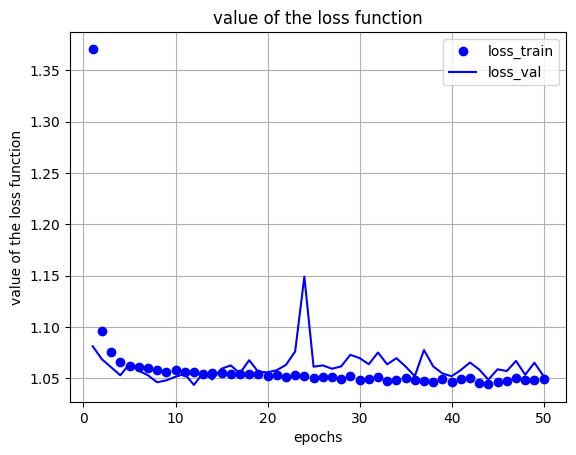

In [ ]:
plot_loss_function(history)

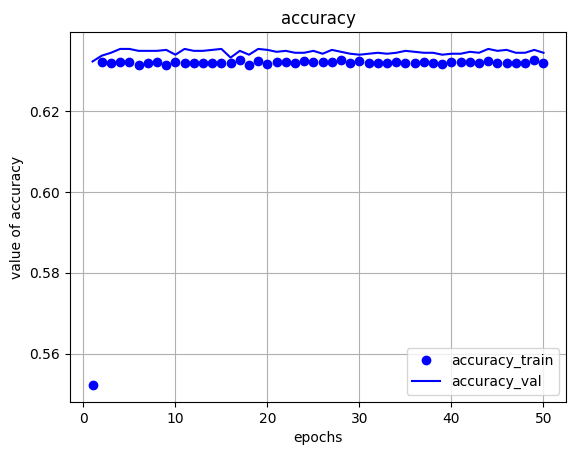

In [ ]:
plot_accuracy(history)

## Model 2

In [ ]:
model = Sequential()

for layer in cnn_model.layers[:-1]:
    layer.trainable = False
    model.add(layer)

# input_shape = (1, HEIGHT, WIDTH, 3)
cnn_output_shape = (None, 32)

model.add(Reshape((cnn_output_shape[1], 1)))

input_shape = (None, 1, 32)
model.add(GRU(units=32, activation="relu", recurrent_activation="relu", bias_initializer=Constant(-1),
              return_sequences=True, input_shape=(input_shape)))
model.add(Dropout(0.2, name="dropout_0.2.1"))
model.add(GRU(units=32, activation="relu", recurrent_activation="relu", bias_initializer=Constant(-1),
              return_sequences=True))
model.add(Flatten(name="flatten.1"))
model.add(Dropout(0.5, name="dropout_0.5.1"))
model.add(Dense(8, activation = "softmax", name="dense_8"))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)       

In [ ]:
X_train = train_images
y_train = train_labels

X_train.shape, y_train.shape

((37758, 48, 48, 1), (37758, 8))

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(val_images, val_labels),
    epochs=50,
    batch_size=32
)

Epoch 1/50
1180/1180 [==============================] - 222s 185ms/step - loss: 1.6167 - accuracy: 0.6314 - val_loss: 1.3131 - val_accuracy: 0.6320
Epoch 2/50
1180/1180 [==============================] - 219s 185ms/step - loss: 1.2083 - accuracy: 0.6321 - val_loss: 1.1495 - val_accuracy: 0.6320
Epoch 3/50
1180/1180 [==============================] - 215s 183ms/step - loss: 1.1241 - accuracy: 0.6321 - val_loss: 1.1100 - val_accuracy: 0.6323
Epoch 4/50
1180/1180 [==============================] - 218s 185ms/step - loss: 1.0934 - accuracy: 0.6322 - val_loss: 1.0870 - val_accuracy: 0.6323
Epoch 5/50
1180/1180 [==============================] - 217s 184ms/step - loss: 1.0794 - accuracy: 0.6317 - val_loss: 1.0712 - val_accuracy: 0.6327
Epoch 6/50
1180/1180 [==============================] - 218s 184ms/step - loss: 1.0733 - accuracy: 0.6322 - val_loss: 1.0651 - val_accuracy: 0.6327
Epoch 7/50
1180/1180 [==============================] - 218s 185ms/step - loss: 1.0737 - accuracy: 0.6321 - val_

In [ ]:
plot_loss_function(history)

NameError: name 'plot_loss_function' is not defined

In [ ]:
plot_accuracy(history)

## Model N - a lot of layers

In [ ]:
model = Sequential()

for layer in cnn_model.layers[:-1]:
    layer.trainable = False
    model.add(layer)

# input_shape = (1, HEIGHT, WIDTH, 3)
cnn_output_shape = (None, 32)

model.add(Reshape((cnn_output_shape[1], 1)))

input_shape = (None, 1, 32)
model.add(GRU(units=32, return_sequences=True, input_shape=(input_shape)))
model.add(GRU(units=32, return_sequences=True))
model.add(Dropout(0.2, name="dropout_0.2"))
model.add(BatchNormalization(name="batch_normalization.1"))
model.add(GRU(units=64, return_sequences=True))
model.add(GRU(units=64, return_sequences=True))
model.add(Dropout(0.4, name="dropout_0.4.1"))
model.add(GRU(units=128, return_sequences=True))
model.add(GRU(units=128))
model.add(Dropout(0.4, name="dropout_0.4.2"))
model.add(Flatten(name="flatten.1"))
model.add(Dense(64, activation="relu", name="dense_256"))
model.add(Dropout(0.5, name="dropout_0.5.1"))
model.add(Dense(32, activation="relu", name="dense_32.1"))
model.add(Dropout(0.3, name="dropout_0.3.1"))
model.add(BatchNormalization(name="batch_normalization.2"))
model.add(Dense(8, activation = "softmax", name="dense_8"))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)      

### Train model

In [ ]:
X_train = train_images
y_train = train_labels

X_train.shape, y_train.shape

((37758, 48, 48, 1), (37758, 8))

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(val_images, val_labels),
    epochs=50,
    batch_size=32
)

Epoch 1/50
1180/1180 [==============================] - 355s 287ms/step - loss: 1.2842 - accuracy: 0.5765 - val_loss: 1.0950 - val_accuracy: 0.6320
Epoch 2/50
1180/1180 [==============================] - 341s 289ms/step - loss: 1.0976 - accuracy: 0.6319 - val_loss: 1.0964 - val_accuracy: 0.6320
Epoch 3/50
1180/1180 [==============================] - 334s 283ms/step - loss: 1.0977 - accuracy: 0.6315 - val_loss: 1.0922 - val_accuracy: 0.6320
Epoch 4/50
1180/1180 [==============================] - 346s 293ms/step - loss: 1.0918 - accuracy: 0.6320 - val_loss: 1.0910 - val_accuracy: 0.6320
Epoch 5/50
 778/1180 [==================>...........] - ETA: 1:47 - loss: 1.0884 - accuracy: 0.6323

KeyboardInterrupt: 

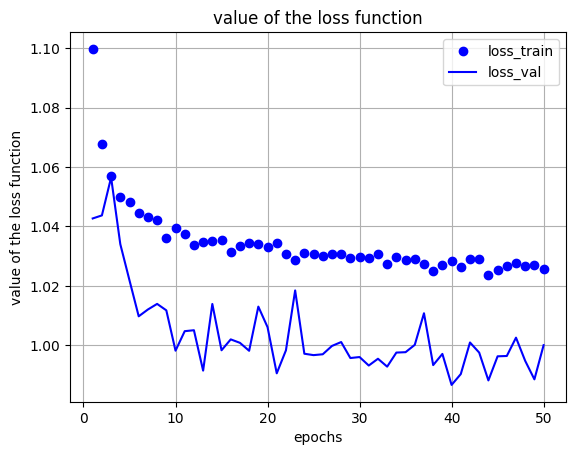

In [ ]:
plot_loss_function(history)

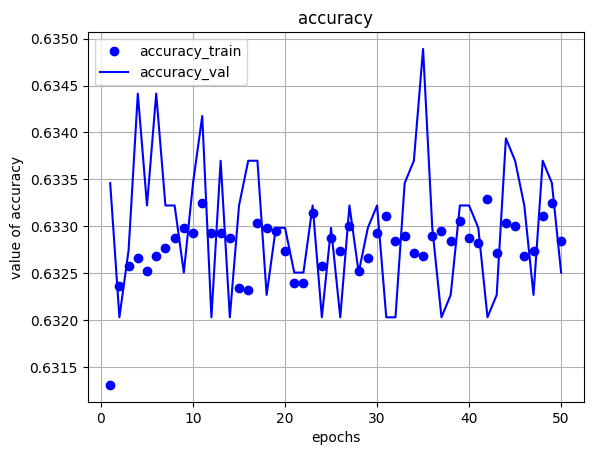

In [ ]:
plot_accuracy(history)

## Model 3 - Only GRU

In [25]:
model3 = Sequential()

for layer in cnn_model.layers[:-1]:
    layer.trainable = False
    model3.add(layer)

cnn_output_shape = (None, 32)

model3.add(Reshape((cnn_output_shape[1], 1)))

input_shape = (None, 1, 32)
model3.add(GRU(units=100, activation="tanh", recurrent_activation="relu", bias_initializer=Constant(-1),
              return_sequences=True, input_shape=(input_shape)))
model3.add(GRU(100, return_sequences=True))
model3.add(GRU(50, return_sequences=False))


model3.add(Dense(8, activation = "softmax", name="dense_8"))
model3.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)       

### Train Model

In [26]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history3 = model3.fit(train_images,
                    train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=50,
                    batch_size=32,
                   callbacks=[early_stopping])

Epoch 1/50
1180/1180 [==============================] - 287s 237ms/step - loss: nan - accuracy: 0.3801 - val_loss: nan - val_accuracy: 0.1997
Epoch 2/50
1180/1180 [==============================] - 271s 230ms/step - loss: nan - accuracy: 0.1998 - val_loss: nan - val_accuracy: 0.1997
Epoch 3/50
1180/1180 [==============================] - 273s 231ms/step - loss: nan - accuracy: 0.1998 - val_loss: nan - val_accuracy: 0.1997
Epoch 4/50
1180/1180 [==============================] - 272s 231ms/step - loss: nan - accuracy: 0.1998 - val_loss: nan - val_accuracy: 0.1997
Epoch 5/50
 478/1180 [===========>..................] - ETA: 2:33 - loss: nan - accuracy: 0.2038

KeyboardInterrupt: 

## Model 4

In [31]:
model4 = Sequential()

for layer in cnn_model.layers[:-1]:
    layer.trainable = False
    model4.add(layer)

cnn_output_shape = (None, 32)

model4.add(Reshape((cnn_output_shape[1], 1)))

input_shape = (None, 1, 32)
model4.add(GRU(units=128, activation="tanh", recurrent_activation="relu", bias_initializer=Constant(-1),
              return_sequences=True, input_shape=(input_shape)))
model4.add(GRU(100, return_sequences=True))

model4.add(Dropout(0.5, name="dropout_0.5.1"))
model4.add(BatchNormalization(name="batch_normalization.1"))

model4.add(GRU(50, return_sequences=True))
model4.add(Dropout(0.5, name="dropout_0.5.2"))
model4.add(BatchNormalization(name="batch_normalization.2"))

model4.add(Flatten(name="flatten.1"))
model4.add(Dense(64, activation="relu", name="dense_256"))
model4.add(Dropout(0.5, name="dropout_0.5.3"))

model4.add(BatchNormalization(name="batch_normalization.3"))

model4.add(Dense(8, activation = "softmax", name="dense_8"))
model4.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)       

### Train Model

In [32]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history4 = model4.fit(train_images,
                    train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=50,
                    batch_size=32,
                   callbacks=[early_stopping])

Epoch 1/50
1180/1180 [==============================] - 305s 251ms/step - loss: 1.3484 - accuracy: 0.5581 - val_loss: 1.0958 - val_accuracy: 0.6320
Epoch 2/50
1180/1180 [==============================] - 292s 248ms/step - loss: 1.1036 - accuracy: 0.6320 - val_loss: 1.1074 - val_accuracy: 0.6320
Epoch 3/50
1180/1180 [==============================] - 294s 249ms/step - loss: 1.0942 - accuracy: 0.6317 - val_loss: 1.0834 - val_accuracy: 0.6320
Epoch 4/50
1180/1180 [==============================] - 293s 249ms/step - loss: 1.0919 - accuracy: 0.6315 - val_loss: 1.0844 - val_accuracy: 0.6320
Epoch 5/50
1180/1180 [==============================] - 294s 249ms/step - loss: 1.0889 - accuracy: 0.6321 - val_loss: 1.0887 - val_accuracy: 0.6320
Epoch 6/50
1180/1180 [==============================] - 293s 248ms/step - loss: 1.0875 - accuracy: 0.6319 - val_loss: 1.0813 - val_accuracy: 0.6318
Epoch 7/50
1180/1180 [==============================] - 303s 257ms/step - loss: 1.0880 - accuracy: 0.6319 - val_